In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [2]:
# import os
# os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\BROJA_2PID')
# from BROJA_2PID import pid, BROJA_2PID_Exception

In [3]:
def Histo3D2Dict(P):
    PDF = dict()
    for i in range(np.size(P, 0)):
        for j in range(np.size(P, 1)):
            for k in range(np.size(P, 2)):
                PDF[(k,i,j)] = float(P[i,j,k])
    return PDF

In [4]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [5]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt
                
        PDF=Histo3D2Dict(pxvr)
        BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
        Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
        Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
        Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
        Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [6]:
def STA(r, x, v, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    vSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        vSTS = vSTS + v[i+negshift:i+posshift]*r[i]
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    vSTA = vSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA, vSTA

In [7]:
#main
Tot=300
dt=1./60
T=np.arange(dt,Tot,dt)
# HMM ; input
Gamma = 4.5
Omega = Gamma/2.12
D = 27*10**5
HMM=np.zeros(len(T))
vL =np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    HMM[i+1]=HMM[i]+vL[i]*dt
    vL[i+1]=vL[i]*(1-dt*Gamma)- Omega**2*HMM[i]*dt+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 1
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

In [8]:
##Choose x and calculate v
x = LPOU  ##HMM or OU or LPOU
v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
v=v[1:-1]
# v =np.diff(x)/dt
# v=v[0:-1] #cut ends.  V(n) = X(n) -X(n-1)
x=x[1:-1]
T=T[1:-1]

(0.0, 5.0)

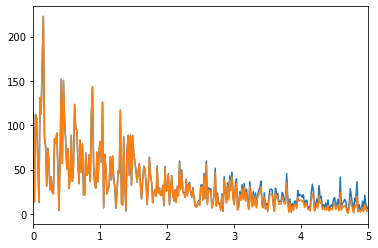

In [9]:
#Fourier analysis 
Ts=dt
xft=fft(OU)
xftreal = xft.real  
xftimg = xft.imag
xft_abs=abs(xft)
xft_nor=xft_abs/len(xft_abs)
xft_nor2=xft_nor[range(int(len(xft_nor)/2))]

f = np.arange(len(xft))
f2 = f[range(int(len(xft)/2))]
f2=f2*Ts
plt.plot(f2,xft_nor2)

xft=fft(LPOU)
xftreal = xft.real  
xftimg = xft.imag
xft_abs=abs(xft)
xft_nor=xft_abs/len(xft_abs)
xft_nor2=xft_nor[range(int(len(xft_nor)/2))]

f = np.arange(len(xft))
f2 = f[range(int(len(xft)/2))]
f2=f2*Ts
plt.plot(f2,xft_nor2)
plt.xlim(0,5)

(140.0, 160.0)

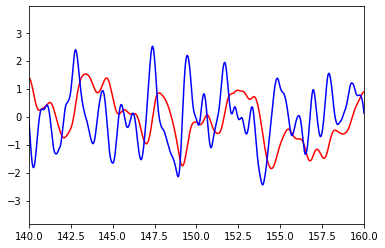

In [10]:
x_n = (x-np.mean(x))/np.std(x)
v_n = (v-np.mean(v))/np.std(v)
plt.plot(T,x_n, 'r-')
plt.plot(T,v_n, 'b-')
plt.xlim(140,160)

0.4833333333333343

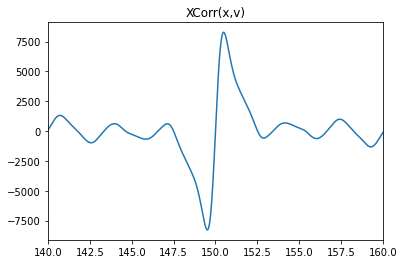

In [20]:
xv_cor = np.correlate(x_n, v_n, "same")
plt.plot(T,xv_cor)
plt.title('XCorr(x,v)')
plt.xlim(140,160)
# Taxis = np.flip(T[:len(xv_cor)]-dt/2)
# t_cor = np.interp(0.5*max(xv_cor),  xv_cor, Taxis)
# t_cor
np.squeeze(T[np.where(xv_cor == max(xv_cor))]-T[np.where(xv_cor == min(xv_cor))])/2

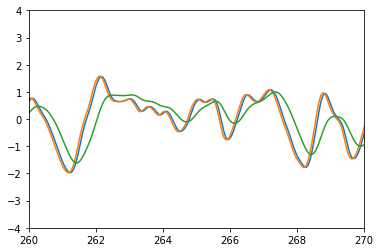

In [12]:
##response
# Model one: simple estimation
deltaT = 0.5
alpha = 1
beta = 0.5
r1 = alpha*x+v*beta
# Model Two: negative group delay
#following paremeters match x+v*0.5s
alpha = 60. #1/sec
beta =  2
K = 30.
g = 30.

# alpha = 60.
# beta =  2
# K = 30.
# g = 30.
#following paremeters match x+v*2s
# alpha = 19.9
# beta =  0.62
# K = 10
# g = 30
# alpha = 20.
# beta =  0.3
# K = 20.
# g = 30.
y=np.zeros(len(T))
z=np.zeros(len(T))
for j in range(len(T)-1):
    dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
    dz=dt*(-beta*z[j]+g*y[j])
    y[j+1]=y[j]+dy
    z[j+1]=z[j]+dz

y= (y-np.mean(y))/np.std(y)
r1= (r1-np.mean(r1))/np.std(r1)
plt.plot(T,y)
plt.plot(T,r1)
plt.plot(T,x_n)
plt.xlim(260,270)
plt.ylim(-4,4)

#Chose which one to be response
r = r1    

In [21]:
y

array([ 0.07887376, -0.00587811, -0.29884955, ...,  0.35841542,
        0.35465153,  0.34977423])

In [14]:

#assign states
rstate=np.zeros(len(r))

##'fake distributed'
edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
for i in range(4):
    rstate[r>=edges[i]] = i
rstate = rstate.astype(int)

##'randomly not fire' + 'burst distributed' 
# counter = 0
# burst_distr = np.array([0.95, 0.03, 0.02]);
# for n in np.arange(1,3):
#     edge = np.sort(r)[int(counter)]
#     counter += int(len(r)*burst_distr[n]/(1-burst_distr[0])+0.5)
#     rstate[r>=edge] = n
# randomly_not_fire = np.append(np.ones(int(len(r)*(1-burst_distr[0])+0.5)), np.zeros(int(len(r)*burst_distr[0]+0.5)))
# np.random.shuffle(randomly_not_fire)
# rstate = rstate*randomly_not_fire
# rstate = rstate.astype(int)

##equal state
# rstate, edges = EqualState(r, 6)

(0.275, -0.125, 0.675)

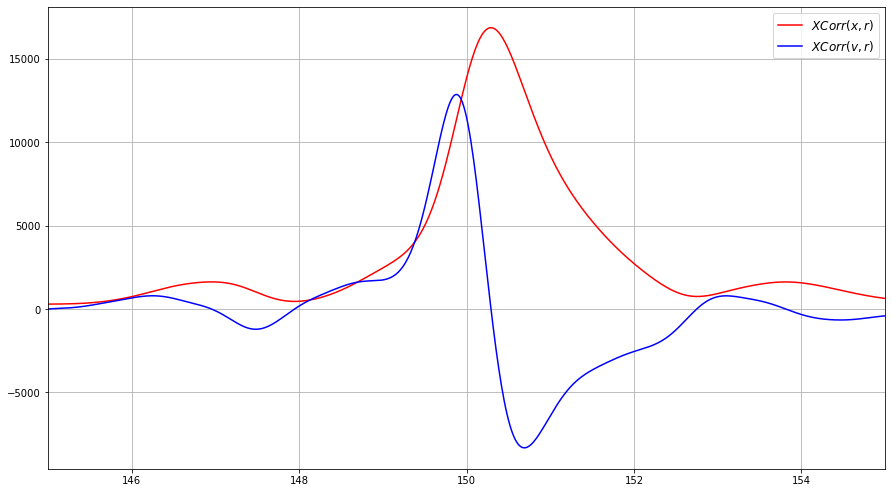

In [15]:
xr_cor = np.correlate(x_n, r, "same")
vr_cor = np.correlate(v_n, r, "same")
plt.plot(T,xr_cor, 'r-')
plt.plot(T,vr_cor, 'b-')
plt.grid()
plt.xlim(145,155)
plt.gcf().set_size_inches(15, 8.5)
plt.legend( (r'$XCorr(x,r)$', r'$XCorr(v,r)$'), loc='best', prop={'size': 'large', 'family': 'monospace'})
(np.squeeze(np.where(xr_cor == max(xr_cor)))-len(T)/2)*dt, (np.squeeze(np.where(vr_cor == max(vr_cor)))-len(T)/2)*dt, (np.squeeze(np.where(vr_cor == min(vr_cor)))-len(T)/2)*dt

In [16]:
#assign states
xstate, edges = EqualState(x, 6)
vstate, edges = EqualState(v, 6)

In [17]:
#calculate STA
window = [-1,1] # second
time, xSTA, vSTA = STA(rstate, x, v, dt, window)

In [18]:
#calculate information
timeshift, Information = PIfunc(rstate, xstate, vstate, dt, window)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in log2
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log2
c:\program files\python37\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply


NameError: name 'pid' is not defined

In [ ]:
#plot PIs (r,x,v)
fig2, (ax2, ax3) = plt.subplots(nrows=2, ncols=1) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_title('Partial Information (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()

ax3.plot(timeshift,Information[('BROJA_2PID','UIx')], 'r-')
ax3.plot(timeshift,Information[('BROJA_2PID','UIv')], 'b-')
ax3.plot(timeshift,Information[('BROJA_2PID','CI')], 'k-')
ax3.plot(timeshift,Information[('BROJA_2PID','SI')], 'g-')
ax3.set_title('Partial Information (BROJA)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax3.legend( (r'$U_x$', r'$U_v$', 'CI', 'SI'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()

# ax4.plot(timeshift,Information[('test','UIx')], 'r-')
# ax4.plot(timeshift,Information[('test','UIv')], 'b-')
# ax4.set_title('Partial Information (test)')
# ax4.set_xlabel('Time(s)')
# ax4.set_ylabel('Information(bit/s)')
# ax4.legend( (r'$U_x$', r'$U_v$', 'CI', 'SI'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# ax4.grid()

plt.gcf().set_size_inches(10.7, 12)
# plt.savefig(str(deltaT)+'_fake_spike_PI.tiff')

In [ ]:
MIx = Information[('Beer','UIx')]+Information[('Beer','Red')]
MIv = Information[('Beer','UIv')]+Information[('Beer','Red')]
MIjoint = Information[('Beer','UIx')]+Information[('Beer','Syn')]+Information[('Beer','UIv')]+Information[('Beer','Red')]
#plot MIs
fig2, (ax2, ax3, ax4) = plt.subplots(nrows=3, ncols=1) 
ax2.plot(timeshift,MIx, 'r-')
ax2.plot(timeshift,MIv, 'b-')
ax2.plot(timeshift,MIjoint, 'k-')
ax2.plot(timeshift,MIx+MIv, 'm-')
ax2.set_title('Mutual Information')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

ax3.plot(time,xSTA,'r-')
ax3.plot(time,vSTA, 'b-')
ax3.set_title('STA')
ax3.set_xlabel('Time(s)')
ax3.legend( ('STA(x)', 'STA(v)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

ax4.plot(time,xr_cor[int(len(T)/2-len(time)/2):int(len(T)/2+len(time)/2)], 'r-')
ax4.plot(time,vr_cor[int(len(T)/2-len(time)/2):int(len(T)/2+len(time)/2)], 'b-')
ax4.set_title('Xcorr')
ax4.set_xlabel('Time(s)')
ax4.legend( ('Xcorr(x,r)', 'Xcorr(n,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})

ax4.grid()
ax3.grid()
ax2.grid()
plt.gcf().set_size_inches(10.7, 18)

In [ ]:
fig2, (ax2) = plt.subplots(nrows=1, ncols=1) 
ax2.plot(timeshift,Information[('Beer','UIx')], 'r-')
ax2.plot(timeshift,Information[('Beer','UIv')], 'b-')
ax2.plot(timeshift,Information[('Beer','Syn')], 'k-')
ax2.plot(timeshift,Information[('Beer','Red')], 'g-')
ax2.set_title('Partial Information (Beer) (r form NF)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
ax2.grid()
plt.gcf().set_size_inches(10.7, 6)

os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code')
plt.savefig('r=y_fake_spike_PI.tiff')

In [ ]:
str(deltaT)